<center><a href="https://5loi.com/about_loi"><img src="images/DLI_Header.png" width="400" height="186" /></a></center>

# 5b. 迁移学习

到目前为止，我们已使用大型数据集训练出了精确的模型，并且还下载了无需训练的开箱即用式预训练模型。但是，如果您找不到完全满足自身需求的预训练模型，那该怎么办？如果没有足够大的数据集可供从头训练模型，又该怎么办？本例中，我们可以使用一种非常有用的方法，此方法称为[迁移学习](https://blogs.nvidia.com/blog/2019/02/07/what-is-transfer-learning/)。

通过迁移学习，您可以利用一个预训练模型，并使用与原始训练任务存在部分重叠的任务对其进行重新训练。对于这种情况，一个绝妙的类比是，精通一种绘画方法（例如油画）的美术家想学着练习另一种绘画方法（例如素描）。可以想象，他们在创作油画时学到的技巧对于学习素描非常有用。

举个深度学习的例子，假设您有一个非常擅长识别不同汽车类型的预训练模型，现在您希望训练一个模型来识别各种类型的摩托车。那个识别汽车的模型所学到的大量知识对您可能很有帮助，比如它已经能够识别出前灯和车轮。

在您没有种类繁多的大型数据集时，迁移学习尤其有用。本例中，从头开始训练的模型很可能会快速记住训练集的数据，但却无法有效地泛化至新数据。通过迁移学习，您有更大的几率在小数据集上训练出精确、稳健的模型。

## 5b.1 目标

完成本节内容的学习后，您将能够：
* 准备预训练模型以进行迁移学习
* 在预训练模型上，利用您自己的小型数据集进行迁移学习
* 进一步优化该模型，从而获得更出色的性能

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import torchvision.io as tv_io

import glob
import json
from PIL import Image

import utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

## 5b.2 个性化的狗门

在上一个练习中，我们使用预训练的 [ImageNet](http://www.image-net.org/) 模型允许所有狗进入，但阻止其他动物进入。本练习中，我们要创建一个只允许特定狗进入的狗门。本例中，我们将为名为 Bo 的狗制作自动狗门。您可能知道 Bo 是巴拉克·奥巴马总统家的狗。您可在 `data/presidential_doggy_door` 文件夹中找到 Bo 的图片。

<img src="data/presidential_doggy_door/train/bo/bo_10.jpg">

本练习的挑战在于，预训练模型并非专用于识别这只狗，而且我们只有 30 张 Bo 的图片。如果我们尝试使用这 30 张图片从头训练模型，则会遇到过拟合和泛化性差的问题。但是，如果我们从一个擅长检测狗的预训练模型开始，则在使用这个小型数据集的情况下，我们可利用该模型学习到的知识获得对 Bo 的一般性的了解，进而使用迁移学习解决此难题。

### 5b.2.1 下载预训练模型

[ImageNet torchvision.models](https://pytorch.org/vision/stable/models.html) 预训练模型是用于计算机视觉领域里的迁移学习的明智选择，因为这些模型已经学会对各种不同类型的图像进行分类。通过训练，它们学会了检测许多不同类型的 [特征](https://developers.google.com/machine-learning/glossary#)，而这些特征对于图像识别非常重要。由于 ImageNet 模型已学会检测包括狗在内的多种动物，因此它尤其适合完成检测 Bo 的迁移学习的任务。

我们先来下载预训练模型。

In [2]:
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights

# load the VGG16 network *pre-trained* on the ImageNet dataset
weights = VGG16_Weights.DEFAULT
vgg_model = vgg16(weights=weights)

这次下载与上一次相比将有一个重要的区别。ImageNet 模型的最后一层是包含 1000 个单元的[密集连接层](https://developers.google.com/machine-learning/glossary#dense-layer)，用来表达数据集中的 1000 个可能的分类。本示例中，我们希望模型作出一个不同的分类：这是或不是 Bo？。可以添加一个新层专门来做是否是 Bo 的分类：

In [3]:
vgg_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 5b.2.2 冻结基础模型

在将新层添加到[预训练模型](https://developers.google.com/machine-learning/glossary#pre-trained-model)之前，我们应当执行一个重要步骤：冻结模型的预训练基础层。这意味着，在进行新的训练时，我们不会更新预训练模型的基础层。相反，我们将仅更新添加到模型末尾的新层。我们冻结基础层，是因为我们希望保留通过 ImageNet 数据集训练时所获得的学习成果。如果在此阶段未冻结这些层，我们很可能会破坏这些重要信息。将来我们可能会需要取消冻结并训练这些层，这将通过后面介绍的名为微调的过程来实现。

冻结基础层非常简单，只需将模型的 [requires_grad_](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html) 参数设置为 `False` 即可。

In [4]:
vgg_model.requires_grad_(False)
print("VGG16 Frozen")

VGG16 Frozen


### 5b.2.3 添加新层

现在，我们可以在预训练模型上添加新的可训练层，它们将利用预训练层中的特征并将其转变成对新数据集的预测。我们会向模型添加两个层。前面我们创建了一个[自定义模型](https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html)。迁移学习模型是一个道理。我们可以继续利用 [Sequential Model](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) 的层。

然后，添加一个连接 VGG16 所有 `1000` 个输出到 `1` 个神经元的 `Linear` 层。

In [5]:
N_CLASSES = 1

my_model = nn.Sequential(
    vgg_model,
    nn.Linear(1000, N_CLASSES)
)

my_model.to(device)

Sequential(
  (0): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): M

可以通过遍历模型的[参数](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)来确认 VGG 层被冻结了。

In [6]:
for idx, param in enumerate(my_model.parameters()):
    print(idx, param.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 True
33 True


如果我们想让 VGG 层能被训练，可以把 `vgg_model` 的 `requires_grad_` 设置为 `True`

In [7]:
vgg_model.requires_grad_(True)
print("VGG16 Unfrozen")
for idx, param in enumerate(my_model.parameters()):
    print(idx, param.requires_grad)

VGG16 Unfrozen
0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 True
15 True
16 True
17 True
18 True
19 True
20 True
21 True
22 True
23 True
24 True
25 True
26 True
27 True
28 True
29 True
30 True
31 True
32 True
33 True


但我们只想训练新的层，所以先把训练选项关掉。

In [8]:
vgg_model.requires_grad_(False)
print("VGG16 Frozen")

VGG16 Frozen


### 5b.2.4 编译模型

和先前的练习一样，我们需要设置损失函数和评价函数选项来编译模型。但此时，我们必须选择一些不同的选项。先前的示例中，我们的分类问题中有很多类别。因此，我们选择使用多分类交叉熵 (categorical cross-entropy) 来计算损失。而本例只是一个二分类问题（Bo 或非 Bo），因此我们将使用[二分类交叉熵 (binary cross-entropy)](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)。如欲详细了解这两者之间的区别，请在[此处](https://gombru.github.io/2018/05/23/cross_entropy_loss/)获取更多内容。另外，我们还将使用二分类精度代替多分类精度作为评价函数。

通过设置 `from_logits=True`，我们可以告知[损失函数](https://gombru.github.io/2018/05/23/cross_entropy_loss/)输出值并未归一化（例如使用 softmax）。

In [9]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = Adam(my_model.parameters())
my_model = my_model.to(device)

与以前一样，这里的模型编译使用了默认优化器RMSProp。

## 5b.3 数据增强

就像之前的课程一样，我们将创建一个自定义的 [Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) 来读取 Bo（和非Bo）的图片。首先，我们将从 VGG 的 `weights` 中获取预处理变换列表。

In [10]:
pre_trans = weights.transforms()

### 5b.3.1 数据集（Dataset）

与之前的课程不同，我们不会从 DataFrame 中读取，而是直接读取图像文件，并根据文件路径推断 `label`。

In [11]:
DATA_LABELS = ["bo", "not_bo"] 
    
class MyDataset(Dataset):
    def __init__(self, data_dir):
        self.imgs = []
        self.labels = []
        
        for l_idx, label in enumerate(DATA_LABELS):
            data_paths = glob.glob(data_dir + label + '/*.jpg', recursive=True)
            for path in data_paths:
                img = Image.open(path)
                self.imgs.append(pre_trans(img).to(device))
                self.labels.append(torch.tensor(l_idx).to(device).float())


    def __getitem__(self, idx):
        img = self.imgs[idx]
        label = self.labels[idx]
        return img, label

    def __len__(self):
        return len(self.imgs)

### 5b.3.2 DataLoaders

现在我们有了自定义的 Dataset 类，让我们创建我们的 [DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders)。

In [12]:
n = 32

train_path = "data/presidential_doggy_door/train/"
train_data = MyDataset(train_path)
train_loader = DataLoader(train_data, batch_size=n, shuffle=True)
train_N = len(train_loader.dataset)

valid_path = "data/presidential_doggy_door/valid/"
valid_data = MyDataset(valid_path)
valid_loader = DataLoader(valid_data, batch_size=n)
valid_N = len(valid_loader.dataset)

### 5b.3.3 数据增强

让我们应用一些数据增强，这样模型就有更好的机会识别 Bo。这次我们有彩色图像，所以我们可以充分利用 [ColorJitter](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#colorjitter)。

In [13]:
IMG_WIDTH, IMG_HEIGHT = (224, 224)

random_trans = transforms.Compose([
    transforms.RandomRotation(25),
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.8, 1), ratio=(1, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.2, contrast=.2, saturation=.2, hue=.2)
])

## 5b.4 训练模型

我们将使用与之前大部分相同的训练循环，但有一些细微的差别。首先，我们的 `lget_batch_accuracy` 函数会有所不同，因为我们使用二元交叉熵作为损失函数。我们可以将输出通过 [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) 函数处理，但我们可以从数学的角度提高效率。

In [14]:
def get_batch_accuracy(output, y, N):
    zero_tensor = torch.tensor([0]).to(device)
    pred = torch.gt(output, zero_tensor)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

打印最后一层的梯度，看看我们新加的这层是否在进行学习。

In [15]:
def train(model, check_grad=False):
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = torch.squeeze(model(random_trans(x)))
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    if check_grad:
        print('Last Gradient:')
        for param in model.parameters():
            print(param.grad)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

取消下面的注释就可以看到一部分模型梯度。因为 VGG16 以 1000 个神经元结束，所以有 1000 个权重连接到下一层的单个神经元。注意，运行之后会打印出很多数字！

In [17]:
train(my_model, check_grad=True)

Last Gradient:
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
tensor([[ 3.6960e-02, -3.9977e-02,  9.5210e-02,  8.9644e-03,  7.8575e-02,
          8.9178e-02, -5.9615e-02, -1.7286e-02, -2.9740e-02,  9.3453e-02,
          1.3663e-01,  7.5705e-02,  7.7369e-02,  1.5545e-01,  9.2218e-03,
          2.2791e-02, -6.6825e-03,  2.7043e-02,  1.5611e-01,  1.0298e-01,
          1.2106e-01,  2.3413e-01,  2.6935e-01,  1.8556e-01,  4.5497e-02,
          8.6975e-02,  1.1957e-01,  5.3562e-02,  2.7641e-02, -3.6993e-02,
          2.6686e-02,  4.2603e-02,  6.5829e-02,  1.2586e-01, -1.6692e-02,
          1.9894e-02,  7.5281e-02, -2.5619e-02, -3.4250e-02,  4.2732e-02,
          1.7034e-02, -4.5692e-02, -9.5835e-02, -3.3539e-02, -3.1967e-02,
         -9.0054e-02, -8.2461e-02, -1.0954e-01, -9.8645e-02, -1.0908e-02,
         -5.2230e-02, -8.8912e-02, -1.6424e-02, -6.2096e-02, -1.5441e-01,
         -4

`validate` 函数基本没什么变化：

In [18]:
def validate(model):
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = torch.squeeze(model(x))

            loss += loss_function(output, y.float()).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

是时候检验成果了：模型能学会识别 Bo 吗？

In [19]:
epochs = 10

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train(my_model, check_grad=False)
    validate(my_model)

Epoch: 0
Train - Loss: 1.7993 Accuracy: 0.8633
Valid - Loss: 0.5727 Accuracy: 0.7000
Epoch: 1
Train - Loss: 1.5836 Accuracy: 0.8849
Valid - Loss: 0.3694 Accuracy: 0.8000
Epoch: 2
Train - Loss: 1.6713 Accuracy: 0.8633
Valid - Loss: 0.2207 Accuracy: 0.9333
Epoch: 3
Train - Loss: 1.3056 Accuracy: 0.8777
Valid - Loss: 0.1872 Accuracy: 0.9333
Epoch: 4
Train - Loss: 1.1554 Accuracy: 0.9209
Valid - Loss: 0.1790 Accuracy: 0.9333
Epoch: 5
Train - Loss: 0.9332 Accuracy: 0.9209
Valid - Loss: 0.1499 Accuracy: 0.9667
Epoch: 6
Train - Loss: 0.9833 Accuracy: 0.9137
Valid - Loss: 0.1200 Accuracy: 0.9667
Epoch: 7
Train - Loss: 0.9709 Accuracy: 0.9281
Valid - Loss: 0.1039 Accuracy: 0.9667
Epoch: 8
Train - Loss: 0.9466 Accuracy: 0.9209
Valid - Loss: 0.0812 Accuracy: 0.9667
Epoch: 9
Train - Loss: 0.8945 Accuracy: 0.9281
Valid - Loss: 0.0672 Accuracy: 0.9667


## 5b.5 讨论结果

希望您会发现训练准确率和验证准确率都非常高。这个结果很棒！能够使用小型数据集进行训练并非难事，但由于利用了从 ImageNet 模型迁移过来的知识，我们还能实现模型的高准确率和有效泛化。也就是说，我们的模型能够非常有效地区分 Bo 和不是 Bo 的宠物。

如果看到验证准确率出现一些波动，这也是正常的。我们将在下一节介绍用于改进模型的方法。

## 5b.6 模型的微调

模型的新层经过训练后，我们还有一个可选的技巧，用于进一步改进模型。这个技巧称为[微调](https://developers.google.com/machine-learning/glossary#f)。要执行此操作，我们需要先解冻整个模型，然后以极小的[学习率](https://developers.google.com/machine-learning/glossary#learning-rate) 重新训练模型。这会让预训练的基础层以非常小的步伐进行微调，从而进一步改进模型的性能。

请注意，只有在包含冻结层和新层的模型经过充分训练后才能执行此步骤，这一点很重要。否则，由于我们先前添加到模型中的新的池化层和分类层是随机地初始化的，我们需要对它们的参数进行大量的更新才能实现准确的图像分类。而通过[反向传播过程](https://developers.google.com/machine-learning/glossary#backpropagation)，在整个模型解冻的状态下，这种对最后两层的大量更新也可能导致预训练层中出现大量更新，从而破坏那些重要的预训练特征。现在这最后2层已经过训练且已收敛，因此再次训练时对模型整体的更新都要小得多（尤其是学习率非常小时），不会破坏前面那些层所预学到的特征。

下面我们就来尝试解冻预训练层，然后微调整个模型：

In [20]:
# Unfreeze the base model
vgg_model.requires_grad_(True)
optimizer = Adam(my_model.parameters(), lr=.000001)

In [21]:
epochs = 2

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train(my_model, check_grad=False)
    validate(my_model)

Epoch: 0
Train - Loss: 0.8948 Accuracy: 0.8993
Valid - Loss: 0.0662 Accuracy: 0.9667
Epoch: 1
Train - Loss: 0.6780 Accuracy: 0.9137
Valid - Loss: 0.0649 Accuracy: 0.9667


我们就少训练几个 `epoch`。因为 VGG16 是个很大的模型，在这个数据集上训练时间过长的话很容易过拟合。

## 5b.7 检查预测结果

现在我们已对模型进行了有效训练，下面我们就来为 Bo 创建狗门！首先让我们看一下模型作出的预测。我们会按照为上一个狗门进行图像预处理的方式来预处理这个图像。

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

In [23]:
def make_prediction(file_path):
    show_image(file_path)
    image = Image.open(file_path)
    image = pre_trans(image).to(device)
    image = image.unsqueeze(0)
    output = my_model(image)
    prediction = output.item()
    return prediction

我们在几个图像上尝试一下，并查看预测结果：

-4.820305347442627

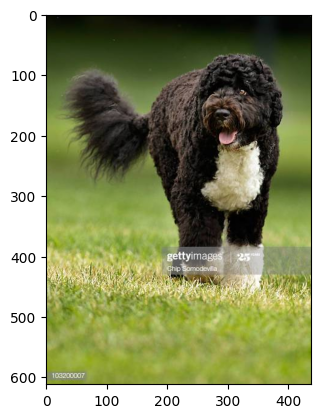

In [24]:
make_prediction('data/presidential_doggy_door/valid/bo/bo_20.jpg')

7.945249080657959

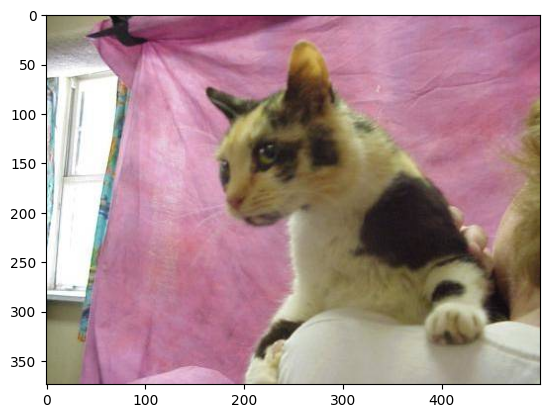

In [25]:
make_prediction('data/presidential_doggy_door/valid/not_bo/121.jpg')

看起来负数预测表示图像中是 Bo，而正数预测表示图像中是其他动物。所以，我们可以使用此信息让狗门只允许 Bo 进入！

## 5b.8 练习：Bo 的狗门

填写下列代码以实现 Bo 的狗门：

### 解答

单击下方的 `...` 查看答案。

In [26]:
# SOLUTION
def presidential_doggy_door(image_path):
    pred = make_prediction(image_path)
    if pred < 0:
        print("It's Bo! Let him in!")
    else:
        print("That's not Bo! Stay out!")

我们来试一试！

That's not Bo! Stay out!


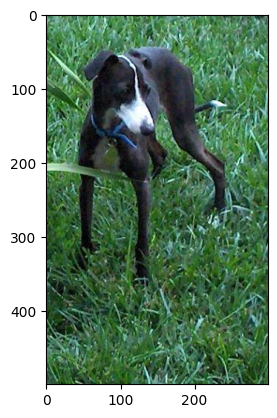

In [27]:
presidential_doggy_door('data/presidential_doggy_door/valid/not_bo/131.jpg')

It's Bo! Let him in!


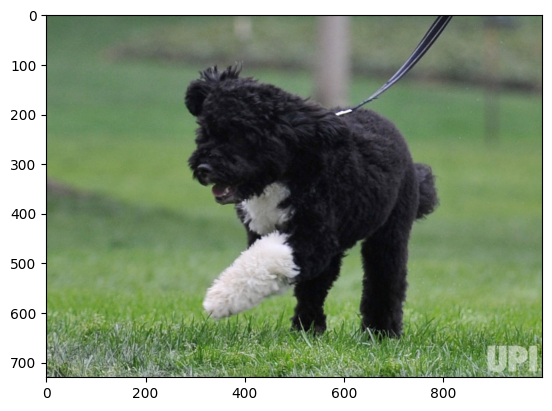

In [28]:
presidential_doggy_door('data/presidential_doggy_door/valid/bo/bo_29.jpg')

## 5b.9 总结

您做得很好！利用迁移学习，您仅使用了一个很小的数据集就构建出了一个高精度的模型。这可谓是一种非常强大的方法，能够决定项目是获得成功还是无法取得进展。我们希望这些方法今后能够在类似的情况下帮助您摆脱困境！

您可以从 [NVIDIA TAO Toolkit](https://developer.nvidia.com/tlt-getting-started) 中获得大量有用的迁移学习资源。

### 5b.9.1 清理显存
继续进行后续内容之前，请执行以下单元清理 GPU 显存。

In [29]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### 5b.9.2 下一步

目前为止，这次研讨会的重点主要聚焦于图像分类。下一节中，为了更全面地介绍深度学习，我们将转而处理序列数据，并将采用不同的方法。